In [41]:
import tensorflow as tf
import numpy as np

from tensorflow import keras

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [42]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
IMG_SIZE = 224
BATCH_SIZE = 16

# 1. Augmentation을 적용한 데이터셋 만들기

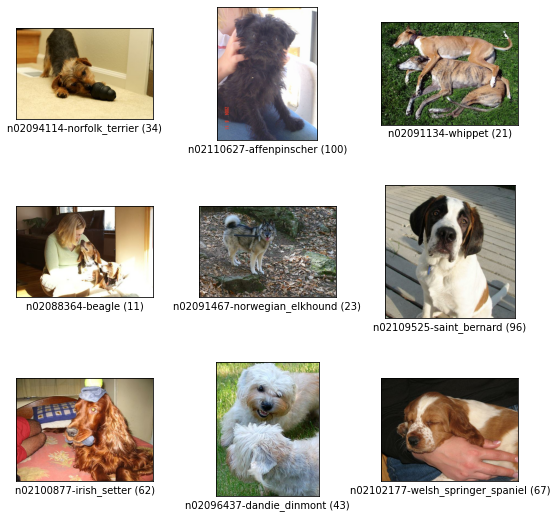

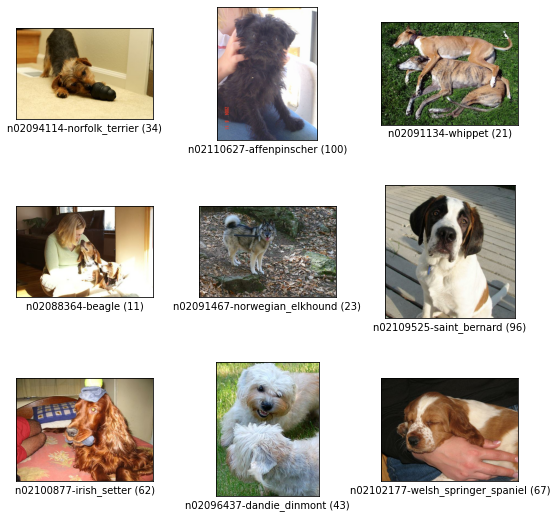

In [44]:
# 데이터 로딩
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


tfds.show_examples(ds_train, ds_info)



In [45]:
num_classes = ds_info.features['label'].num_classes


In [46]:
# 전처리
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return tf.cast(image, tf.float32) / 255., label

def onehot(image, label):
    label = tf.squeeze(label)
    label = tf.one_hot(label, num_classes)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return tf.clip_by_value(image, 0, 1), label

- CutMix

In [47]:
def get_clip_box(image_a, image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    w = tf.cast(image_size_x * tf.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    h = tf.cast(image_size_y * tf.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32)
    return tf.clip_by_value(x - w//2, 0, image_size_x), tf.clip_by_value(y - h//2, 0, image_size_y), \
           tf.clip_by_value(x + w//2, 0, image_size_x), tf.clip_by_value(y + h//2, 0, image_size_y)

def mix_2_images(image_a, image_b, x1, y1, x2, y2):
    middle = tf.concat([
        image_a[y1:y2, 0:x1, :],
        image_b[y1:y2, x1:x2, :],
        image_a[y1:y2, x2:, :]
    ], axis=1)
    return tf.concat([image_a[:y1], middle, image_a[y2:]], axis=0)

def mix_2_labels(label_a, label_b, x1, y1, x2, y2):
    area = (x2 - x1) * (y2 - y1)
    ratio = tf.cast(area / (IMG_SIZE * IMG_SIZE), tf.float32)
    label_a = tf.one_hot(tf.squeeze(label_a), num_classes) if len(label_a.shape) == 0 else label_a
    label_b = tf.one_hot(tf.squeeze(label_b), num_classes) if len(label_b.shape) == 0 else label_b
    return (1 - ratio) * label_a + ratio * label_b

def cutmix(image, label):
    imgs, labels = [], []
    for i in range(BATCH_SIZE):
        j = tf.random.uniform([], 0, BATCH_SIZE, dtype=tf.int32)
        x1, y1, x2, y2 = get_clip_box(image[i], image[j])
        mixed_img = mix_2_images(image[i], image[j], x1, y1, x2, y2)
        mixed_lbl = mix_2_labels(label[i], label[j], x1, y1, x2, y2)
        imgs.append(mixed_img)
        labels.append(mixed_lbl)
    return tf.stack(imgs), tf.stack(labels)

- Mixup

In [48]:
# MixUp
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    label_a = tf.one_hot(tf.squeeze(label_a), num_classes) if len(label_a.shape) == 0 else label_a
    label_b = tf.one_hot(tf.squeeze(label_b), num_classes) if len(label_b.shape) == 0 else label_b
    return (1 - ratio) * image_a + ratio * image_b, (1 - ratio) * label_a + ratio * label_b

def mixup(image, label):
    imgs, labels = [], []
    for i in range(BATCH_SIZE):
        j = tf.random.uniform([], 0, BATCH_SIZE, dtype=tf.int32)
        img, lbl = mixup_2_images(image[i], image[j], label[i], label[j])
        imgs.append(img)
        labels.append(lbl)
    return tf.stack(imgs), tf.stack(labels)


In [49]:
# 데이터셋 구성 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)

    if not is_test and with_aug:
        ds = ds.map(augment, num_parallel_calls=2)

    if not with_cutmix and not with_mixup:
        ds = ds.map(onehot, num_parallel_calls=2)

    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)

    if not is_test:
        ds = ds.shuffle(200).repeat()

    return ds.prefetch(tf.data.AUTOTUNE)

# 2. 모델 만들기
- 모델은 ResNet-50을 사용
- 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용

In [50]:

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [51]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [52]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [53]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [55]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train_raw, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train_raw, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test_raw, is_test=True)
ds_train_cutmix   = apply_normalize_on_dataset(ds_train_raw, with_cutmix=True)   
ds_train_mixup    = apply_normalize_on_dataset(ds_train_raw, with_mixup=True)    



# 3. 모델 훈련하기

In [56]:
for x, y in ds_test.take(1):
    print(y.shape)  # ✅ (16, 120)여야 합니다.


(16, 120)


In [66]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 175s 223ms/step - loss: 0.7766 - accuracy: 0.7753 - val_loss: 1.5734 - val_accuracy: 0.5640
Epoch 2/20
750/750 [==============================] - 170s 227ms/step - loss: 0.2598 - accuracy: 0.9426 - val_loss: 1.0225 - val_accuracy: 0.7078
Epoch 3/20
750/750 [==============================] - 169s 226ms/step - loss: 0.0689 - accuracy: 0.9936 - val_loss: 0.9007 - val_accuracy: 0.7387
Epoch 4/20
750/750 [==============================] - 169s 226ms/step - loss: 0.0264 - accuracy: 0.9986 - val_loss: 0.9256 - val_accuracy: 0.7386
Epoch 5/20
750/750 [==============================] - 169s 226ms/step - loss: 0.0165 - accuracy: 0.9995 - val_loss: 0.9247 - val_accuracy: 0.7445
Epoch 6/20
750/750 [==============================] - 169s 226ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.9388 - val_accuracy: 0.7400
Epoch 7/20
750/750 [==============================] - 169s 226ms/step - loss: 0.0095 - accuracy: 0.9998 - val_loss: 0.9447 -

In [67]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 177s 228ms/step - loss: 0.9597 - accuracy: 0.7212 - val_loss: 1.5960 - val_accuracy: 0.5613
Epoch 2/20
750/750 [==============================] - 169s 226ms/step - loss: 0.5081 - accuracy: 0.8643 - val_loss: 1.1339 - val_accuracy: 0.6736
Epoch 3/20
750/750 [==============================] - 169s 226ms/step - loss: 0.2784 - accuracy: 0.9324 - val_loss: 1.0961 - val_accuracy: 0.6954
Epoch 4/20
750/750 [==============================] - 169s 226ms/step - loss: 0.1619 - accuracy: 0.9663 - val_loss: 1.0937 - val_accuracy: 0.6979
Epoch 5/20
750/750 [==============================] - 170s 227ms/step - loss: 0.0905 - accuracy: 0.9840 - val_loss: 1.0738 - val_accuracy: 0.7055
Epoch 6/20
750/750 [==============================] - 170s 226ms/step - loss: 0.0624 - accuracy: 0.9896 - val_loss: 1.0010 - val_accuracy: 0.7252
Epoch 7/20
750/750 [==============================] - 170s 226ms/step - loss: 0.0396 - accuracy: 0.9958 - val_loss: 0.9660 -

In [ ]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 180s 230ms/step - loss: 2.9161 - accuracy: 0.4381 - val_loss: 1.3509 - val_accuracy: 0.6180
Epoch 2/20
750/750 [==============================] - 171s 228ms/step - loss: 2.5926 - accuracy: 0.5492 - val_loss: 1.4723 - val_accuracy: 0.6034
Epoch 3/20
750/750 [==============================] - 172s 230ms/step - loss: 2.3995 - accuracy: 0.6153 - val_loss: 1.4672 - val_accuracy: 0.5919
Epoch 4/20
750/750 [==============================] - 171s 228ms/step - loss: 2.2415 - accuracy: 0.6597 - val_loss: 1.2017 - val_accuracy: 0.6631
Epoch 5/20
750/750 [==============================] - 172s 229ms/step - loss: 2.1177 - accuracy: 0.7016 - val_loss: 1.2920 - val_accuracy: 0.6518
Epoch 6/20
750/750 [==============================] - 172s 229ms/step - loss: 2.0514 - accuracy: 0.7186 - val_loss: 1.4164 - val_accuracy: 0.6196
Epoch 7/20
750/750 [==============================] - 171s 229ms/step - loss: 1.9613 - accuracy: 0.7509 - val_loss: 1.3081 -

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

# 4. 훈련 과정 시각화하기

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'orange')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Aug', 'CutMix', 'MixUp'], loc='upper right')
plt.show()


In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정
#plt.ylim(0.72, 0.76)  
plt.show()

- 5 에폭씩 더 진행시켜봄

In [ ]:
# No Aug
history_resnet50_no_aug_20 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=25,
    initial_epoch=20,
    validation_data=ds_test,
    verbose=1
)

# Aug
history_resnet50_aug_20 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=25,
    initial_epoch=20,
    validation_data=ds_test,
    verbose=1
)

# CutMix
history_resnet50_cutmix_20 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=25,
    initial_epoch=20,
    validation_data=ds_test,
    verbose=1
)

# MixUp
history_resnet50_mixup_20 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=25,
    initial_epoch=20,
    validation_data=ds_test,
    verbose=1
)


In [ ]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'orange')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Aug', 'CutMix', 'MixUp'], loc='upper right')
plt.show()


In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.90)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

# 5. Augmentation에 의한 모델 성능 비교
- No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석

# 회고
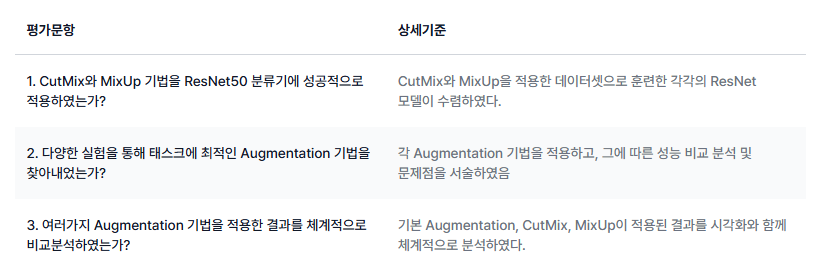